In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
file_path = '/datasets/CIFAR-10'
classes = ('airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck')

In [3]:
def get_train_valid_loader(data_dir, batch_size, valid_size=0.1, shuffle=True, random_seed=0, num_workers=1):
    train_dataset = torchvision.datasets.CIFAR10(root=data_dir, 
                                                 train=True, 
                                                 download=True, 
                                                 transform=transforms.ToTensor())
    valid_dataset = torchvision.datasets.CIFAR10(root=data_dir, 
                                                 train=True, 
                                                 download=True, 
                                                 transform=transforms.ToTensor())
    num_train = len(train_dataset)
    indices = np.array(range(num_train))
    split = int(np.floor(valid_size*num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_index = indices[split:]
    valid_index = indices[:split]
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_index)
    valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_index)
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size, 
                                               sampler=train_sampler, 
                                               num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                               batch_size=batch_size, 
                                               sampler=valid_sampler, 
                                               num_workers=num_workers)
    return train_loader, valid_loader
        

In [4]:
def get_test_loader(data_dir, batch_size, shuffle=False, num_workers=1):
    test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transforms.ToTensor())
    test_loader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size, 
                                              shuffle=shuffle, 
                                              num_workers=num_workers)
    return test_loader

In [14]:
train_loader, valid_loader = get_train_valid_loader(file_path, 64)
test_loader = get_test_loader(file_path, 64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [15]:
class TestNet(nn.Module):
    def __init__(self):
        super(TestNet, self).__init__()
        self.padding = nn.ZeroPad2d(2)
        self.conv1 = nn.Conv2d(3,64,3)
        self.conv2 = nn.Conv2d(64,128,3)
        self.conv3 = nn.Conv2d(128,256,5)
        self.conv4 = nn.Conv2d(256,512,3)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(4*4*512,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,10)
        self.batch_norm1 = nn.BatchNorm2d(3)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.batch_norm4 = nn.BatchNorm2d(256)
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = F.relu(self.conv1(x))
        x = self.padding(x)
        x = self.batch_norm2(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batch_norm3(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.padding(x)
        x = self.batch_norm4(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1,4*4*512)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
def reset_params(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal(m.weight, gain=1)
            m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal(m.weight, gain=1)
            m.bias.data.zero_()

In [9]:
import torch.optim.lr_scheduler

In [16]:
testNet = TestNet().cuda()
reset_params(testNet)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(testNet.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,6,gamma=0.1,last_epoch=-1)

In [11]:
def train_process(num_epoch):
    train_loss = []
    valid_loss = []
    test_loss = []
    train_acc =[]
    valid_acc = []
    test_acc = []
    params = []
    for epoch in range(num_epoch):
        scheduler.step()
        testNet.train()
        for i,(train_ins,train_labels) in enumerate(train_loader,0):
            train_ins = Variable(train_ins).cuda()
            print(train_ins.size())
            train_labels = Variable(train_labels).cuda()
            optimizer.zero_grad()
            train_outs = testNet(train_ins)
            loss = criterion(train_outs, train_labels)
            loss.backward()
            optimizer.step()
        
        testNet.eval()
        score, loss_value = evaluation(train_loader)
        train_acc.append(score)
        train_loss.append(loss_value)
        
        score, loss_value = evaluation(valid_loader)
        valid_acc.append(score)
        valid_loss.append(loss_value)
        
        score, loss_value = evaluation(test_loader)
        test_acc.append(score)
        test_loss.append(loss_value)
        
        print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()),
              'train: %.5f, valid: %.5f, test: %.5f'%(train_loss[epoch],valid_loss[epoch],test_loss[epoch]),
             'train: %.3f, valid: %.3f, test: %.3f'%(train_acc[epoch],valid_acc[epoch],test_acc[epoch]))
            
        validLoss = 0.0
        trainLoss = 0.0
        params.append(testNet.state_dict())
    print('Finish training.')
    return train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc, params

In [12]:
def evaluation(dataloader):
    score = 0.0
    loss = 0.0
    for (ins, labels) in dataloader:
        ins = Variable(ins).cuda()
        outs = testNet(ins)
        _, pred = torch.max(outs.data,1)
        score += (pred == labels.cuda()).sum()/len(labels)
        labels = Variable(labels).cuda()
        loss += criterion(outs,labels).data[0]
    score /= len(dataloader)
    loss /= len(dataloader)
    return score,loss

In [17]:
train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc, params = train_process(1)

torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 3

torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 3

torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 3

In [14]:
train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc, params = train_process(18)

2018-02-13 19:50:02 train: 0.72324, valid: 0.81671, test: 0.83680 train: 0.745, valid: 0.716, test: 0.714
2018-02-13 19:50:25 train: 0.51664, valid: 0.72052, test: 0.71414 train: 0.827, valid: 0.753, test: 0.758
2018-02-13 19:50:48 train: 0.29852, valid: 0.63646, test: 0.64512 train: 0.904, valid: 0.791, test: 0.797
2018-02-13 19:51:11 train: 0.21419, valid: 0.78106, test: 0.77396 train: 0.928, valid: 0.782, test: 0.783
2018-02-13 19:51:34 train: 0.13616, valid: 0.85110, test: 0.82731 train: 0.955, valid: 0.784, test: 0.785
2018-02-13 19:51:57 train: 0.10437, valid: 0.89116, test: 0.90326 train: 0.967, valid: 0.786, test: 0.790
2018-02-13 19:52:19 train: 0.01332, valid: 0.91262, test: 0.94686 train: 0.997, valid: 0.816, test: 0.812
2018-02-13 19:52:41 train: 0.00465, valid: 1.11899, test: 1.15387 train: 0.999, valid: 0.815, test: 0.813
2018-02-13 19:53:03 train: 0.00197, valid: 1.25446, test: 1.29578 train: 1.000, valid: 0.816, test: 0.814
2018-02-13 19:53:26 train: 0.00105, valid: 1.4

In [21]:
train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc, params = train_process(18)

2018-02-13 20:18:03 train: 0.83552, valid: 0.90647, test: 0.89949 train: 0.702, valid: 0.677, test: 0.683
2018-02-13 20:18:28 train: 0.58712, valid: 0.72713, test: 0.75248 train: 0.796, valid: 0.748, test: 0.745
2018-02-13 20:18:54 train: 0.37444, valid: 0.62124, test: 0.63748 train: 0.876, valid: 0.790, test: 0.791
2018-02-13 20:19:20 train: 0.23233, valid: 0.60126, test: 0.60941 train: 0.924, valid: 0.809, test: 0.807
2018-02-13 20:19:45 train: 0.26542, valid: 0.69566, test: 0.73880 train: 0.912, valid: 0.790, test: 0.773
2018-02-13 20:20:11 train: 0.14095, valid: 0.69949, test: 0.74302 train: 0.955, valid: 0.799, test: 0.797
2018-02-13 20:20:36 train: 0.02248, valid: 0.66494, test: 0.72276 train: 0.994, valid: 0.833, test: 0.830
2018-02-13 20:21:01 train: 0.00753, valid: 0.78319, test: 0.84145 train: 0.999, valid: 0.830, test: 0.830
2018-02-13 20:21:27 train: 0.00293, valid: 0.93742, test: 1.00759 train: 0.999, valid: 0.835, test: 0.832
2018-02-13 20:21:53 train: 0.00192, valid: 1.0

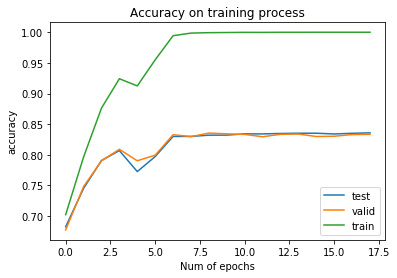

In [25]:
plt.title('Accuracy on training process')
plt.xlabel('Num of epochs')
plt.ylabel('accuracy')
plt.plot(range(18),test_acc,label='test')
plt.plot(range(18),valid_acc,label='valid')
plt.plot(range(18),train_acc,label='train')
plt.legend(loc='lower right')
plt.show()

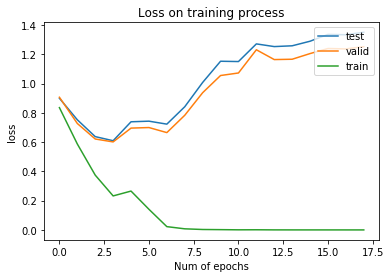

In [24]:
plt.title('Loss on training process')
plt.xlabel('Num of epochs')
plt.ylabel('loss')
plt.plot(range(18),test_loss,label='test')
plt.plot(range(18),valid_loss,label='valid')
plt.plot(range(18),train_loss,label='train')
plt.legend(loc='upper right')
plt.show()